In [1]:
import numpy as np
from casadi import *
from scipy.integrate import ode
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
##------Simple Reaction Example-------------
#  A + B --> C
#  Rate is given by r = kc_Ac_B 
#  

In [3]:
##-------Semi-Batch Reaction------------------

# initial concentration in reactor
cA_0 = 2 # mol/L
cB_0 = 0 # mol/L
cC_0 = 0 # mol/L
# Initial volume (L)
Vinit = 5

# B is fed to reactor over 1 hour at the rate of 1/12 L/min (5L over 60 min) 
# with concentration of 2 mol/L
qF = 1/12 # L/min
cB_F = 2 # mol/L
tfeed = 60* 60 # seconds

# Simulation time (sec)
tf = 5*3600

# rate constant
k = 5e-4 # L/mol.s

In [4]:
##-------Solve using scipy---------------
def rate(t, y, k, qF, tfeed, cB_F, Vinit):
    
    if t <= tfeed:
        V = Vinit + (qF / 60) * t
        qin = qF / 60
        cBin = cB_F
    else:
        V = Vinit + (qF / 60) * tfeed
        qin = 0
        cBin = 0
    
    cA = y[0]
    cB = y[1]
    cC = y[2]
    r = k * cA * cB
    
    dA = -(qin/V) * cA - r
    dB = (qin/V) * (cBin - cB) - r
    dC = -(qin/V) * cC + r
    
    dy = [dA, dB, dC]
    
    return dy

In [5]:
tgrid = np.linspace(0, tf, 100)
sol = np.zeros((len(tgrid), 3))
sol[0, :] = [cA_0, cB_0, cC_0]

In [6]:
r = ode(rate).set_integrator('vode', method = "BDF")
r.set_initial_value([cA_0, cB_0, cC_0]).set_f_params(k, qF, tfeed, cB_F, Vinit)

i = 0
for i in range(len(tgrid) - 1):
    t = tgrid[i]
    dt = tgrid[i + 1] - tgrid[i]
    sol[i + 1] = r.integrate(t + dt)

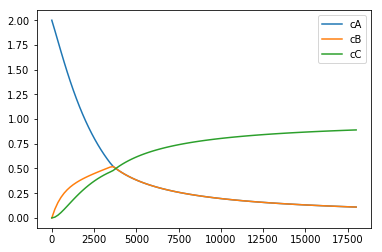

In [7]:
plt.plot(tgrid, sol[:, 0], label = "cA")
plt.plot(tgrid, sol[:, 1], label = "cB")
plt.plot(tgrid, sol[:, 2], label = "cC")
plt.legend()
plt.show()

In [8]:
##----------Solve using CasADi-------------------------
cA = SX.sym('cA')
cB = SX.sym('cB')
cC = SX.sym('cC')
V = SX.sym('V')
x = vertcat(cA, cB, cC, V)

k = SX.sym('k')
qin = SX.sym('qin')
cBin = SX.sym('cBin')

p = vertcat(k, qin, cBin)

In [9]:
r1 = k * cA * cB
dA = -qin/V * cA -r1
dB = qin/V * (cBin - cB) -r1
dC = -qin/V * cC + r1
dV = qin
f = vertcat(dA, dB, dC, dV)

In [10]:
prob = {'x' : x, 'p' : p, 'ode' : f}

In [11]:
cA_0 = 2
cB_0 = 0
cC_0 = 0
Vinit = 5

In [12]:
# time points where parameters change
keytimes = [0.0, tfeed, tf]
# paramter values for each of the above time intervals
pin = np.array([[5e-4, 1/(12*60), 2],
                [5e-4, 0.0, 2]
               ])
# solve integrator for each time interval
for i in range(len(keytimes) - 1):
    print(i)
    tinit = keytimes[i]
    tfinal = keytimes[i + 1]
    tgrid = np.linspace(tinit, tfinal, 100)
    op = {'t0': tinit, 'tf' : tfinal, 'grid' : tgrid, 'output_t0' : True}
    F = integrator('F', 'cvodes', prob, op)
    if i == 0:
        x0 = [cA_0, cB_0, cC_0, Vinit]
    else:
        x0 = solcasfull[-1, :]
    solcas = F(x0 = x0, p = pin[i,:])
    if i == 0:
        solcasfull = solcas['xf'].full().T
        tfull = tgrid
    else:
        solcasfull = np.vstack((solcasfull, solcas['xf'].full().T))
        tfull = np.hstack((tfull, tgrid))

0
1


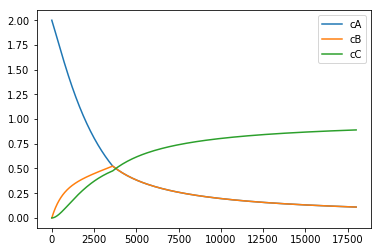

In [13]:
plt.plot(tfull, solcasfull[:, 0], label = "cA")
plt.plot(tfull, solcasfull[:, 1], label = "cB")
plt.plot(tfull, solcasfull[:, 2], label = "cC")
plt.legend()
plt.show()